**Unzipping Dataset**

In [ ]:
!unzip '/content/drive/MyDrive/Furniture Style Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Furniture Style Dataset/Traditional_Chairs/10009traditional-recliner-chairs.jpg  
  inflating: Furniture Style Dataset/Traditional_Chairs/10010traditional-folding-chairs-and-stools.jpg  
  inflating: Furniture Style Dataset/Traditional_Chairs/10015traditional-recliner-chairs.jpg  
  inflating: Furniture Style Dataset/Traditional_Chairs/10017traditional-recliner-chairs.jpg  
  inflating: Furniture Style Dataset/Traditional_Chairs/10020traditional-recliner-chairs.jpg  
  inflating: Furniture Style Dataset/Traditional_Chairs/10022traditional-recliner-chairs.jpg  
  inflating: Furniture Style Dataset/Traditional_Chairs/10024traditional-recliner-chairs.jpg  
  inflating: Furniture Style Dataset/Traditional_Chairs/10029traditional-armchairs-and-accent-chairs.jpg  
  inflating: Furniture Style Dataset/Traditional_Chairs/10030traditional-armchairs-and-accent-chairs.jpg  
  inflating: Furniture Style Dataset/Traditional_Chairs/1003

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
image_dir = Path('/content/Furniture Style Dataset')

In [ ]:
print(len(list(image_dir.glob(r'**/*.jpg'))))

12000


In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df['Label'].value_counts()

Modern_Chairs          1000
Contemporary_Tables    1000
Traditional_Tables     1000
Contemporary_Sofas     1000
Transitional_Chairs    1000
Transitional_Beds      1000
Traditional_Chairs     1000
Traditional_Beds       1000
Modern_Tables          1000
Transitional_Sofas     1000
Contemporary_Beds      1000
Contemporary_Chairs    1000
Name: Label, dtype: int64

In [ ]:
samples = []
for category in image_df['Label'].unique():
  category_slice = image_df.query("Label == @category")
  samples.append(category_slice.sample(1000, random_state=1))
image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
image_df['Label'].value_counts()

Modern_Chairs          1000
Contemporary_Tables    1000
Traditional_Tables     1000
Contemporary_Sofas     1000
Transitional_Chairs    1000
Transitional_Beds      1000
Traditional_Chairs     1000
Traditional_Beds       1000
Modern_Tables          1000
Transitional_Sofas     1000
Contemporary_Beds      1000
Contemporary_Chairs    1000
Name: Label, dtype: int64

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 6720 validated image filenames belonging to 12 classes.
Found 1680 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

pretrained_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = 7
)

Epoch 1/7
210/210 [==============================] - 26s 113ms/step - loss: 1.4455 - accuracy: 0.4511 - val_loss: 1.0235 - val_accuracy: 0.5583
Epoch 2/7
210/210 [==============================] - 23s 110ms/step - loss: 0.8876 - accuracy: 0.6147 - val_loss: 0.9803 - val_accuracy: 0.5839
Epoch 3/7
210/210 [==============================] - 23s 109ms/step - loss: 0.7599 - accuracy: 0.6755 - val_loss: 0.9269 - val_accuracy: 0.6089
Epoch 4/7
210/210 [==============================] - 23s 109ms/step - loss: 0.6581 - accuracy: 0.7319 - val_loss: 1.0082 - val_accuracy: 0.5857
Epoch 5/7
210/210 [==============================] - 23s 108ms/step - loss: 0.5878 - accuracy: 0.7582 - val_loss: 1.0586 - val_accuracy: 0.5774
Epoch 6/7
210/210 [==============================] - 23s 109ms/step - loss: 0.4844 - accuracy: 0.8151 - val_loss: 1.0631 - val_accuracy: 0.5935
Epoch 7/7
210/210 [==============================] - 23s 109ms/step - loss: 0.4262 - accuracy: 0.8306 - val_loss: 1.1778 - val_accuracy:

In [ ]:
class_names = list(test_images.class_indices.keys())
class_names

['Contemporary_Beds',
 'Contemporary_Chairs',
 'Contemporary_Sofas',
 'Contemporary_Tables',
 'Modern_Chairs',
 'Modern_Tables',
 'Traditional_Beds',
 'Traditional_Chairs',
 'Traditional_Tables',
 'Transitional_Beds',
 'Transitional_Chairs',
 'Transitional_Sofas']

113/113 [==============================] - 10s 89ms/step - loss: 1.1499 - accuracy: 0.6000
Test Accuracy: 60.00%


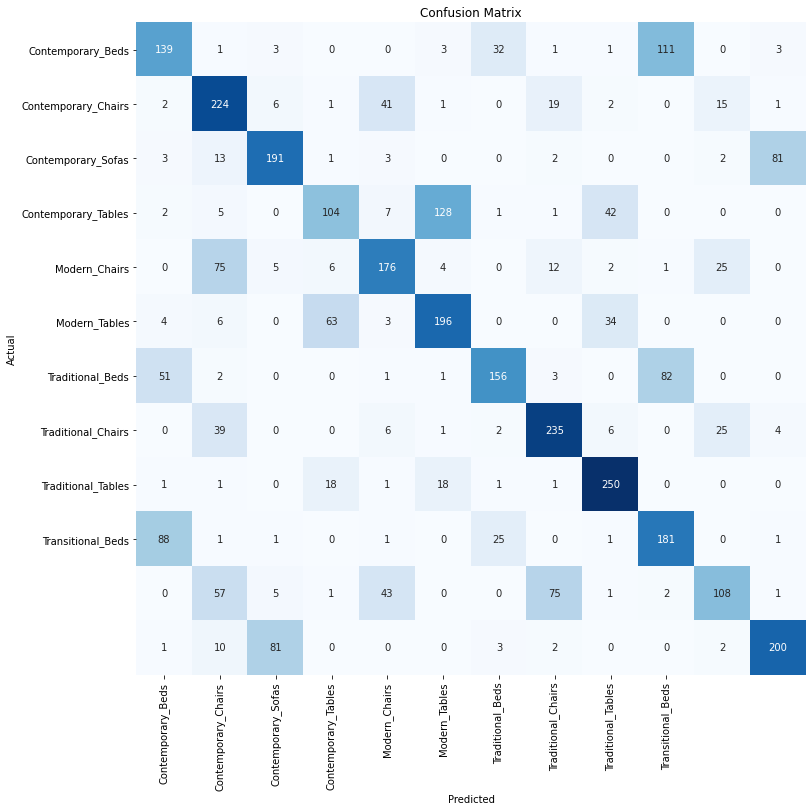

Classification Report:
-------------------
                      precision    recall  f1-score   support

  Contemporary_Beds       0.48      0.47      0.48       294
Contemporary_Chairs       0.52      0.72      0.60       312
 Contemporary_Sofas       0.65      0.65      0.65       296
Contemporary_Tables       0.54      0.36      0.43       290
      Modern_Chairs       0.62      0.58      0.60       306
      Modern_Tables       0.56      0.64      0.60       306
   Traditional_Beds       0.71      0.53      0.60       296
 Traditional_Chairs       0.67      0.74      0.70       318
 Traditional_Tables       0.74      0.86      0.79       291
  Transitional_Beds       0.48      0.61      0.54       299
Transitional_Chairs       0.61      0.37      0.46       293
 Transitional_Sofas       0.69      0.67      0.68       299

           accuracy                           0.60      3600
          macro avg       0.60      0.60      0.59      3600
       weighted avg       0.60      0.6

In [ ]:
results = model.evaluate(test_images, verbose = 1)
predictions = np.argmax(model.predict(test_images), axis = 1)

class_names = list(test_images.class_indices.keys())
cm = confusion_matrix(test_images.labels, predictions, labels = np.arange(12))
clr = classification_report(test_images.labels, predictions, labels = np.arange(12), target_names = class_names)

print("Test Accuracy: {:.2f}%".format(results[1] * 100))
plt.figure(figsize = (12,12))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(10) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(10) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-------------------\n", clr)

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])